# The CMB as a Gaussian Process

_[Boris Leistedt](http://ixkael.com/), May 2017. Comments welcome!_ 

This notebook is available at [on Github](https://github.com/ixkael/Prob-tools/blob/master/notebooks/The%20CMB%20as%20a%20Gaussian%20Process.ipynb). 

We will briefly present the cosmic microwave background and use standard analysis packages to compute the power spectrum and the pixel-pixel correlation kernel. This should be a good starting point to think about the CMB as a Gaussian Process and maybe develop new analysis techniques that allow us to work with a full-resolution CMB maps (notably for inverse covariance matrix and likelihood calls), which is not currently possible.

### Requirements

`matplotlib`, `scipy`, `numpy`

- `camb`: http://camb.readthedocs.io/en/latest/
- `healpy`: https://healpy.readthedocs.io/en/latest/ 

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from cycler import cycler

import numpy as np

rc("font", family="serif", size=14)
rc("text", usetex=True)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['patch.linewidth'] = 2
matplotlib.rcParams['axes.prop_cycle'] =\
    cycler("color", ['k', 'c', 'm', 'y'])
matplotlib.rcParams['axes.labelsize'] = 16

import healpy as hp

import camb
from camb import model, initialpower

## CMB Temperature fluctuations
In the absence of foregrounds and ignoring spectral distortions, the temperature of the microwave sky (at an arbitrary frequency), denoted by $T(\vec{n})$ with $\vec{n} \equiv (\theta, \phi) \in S^2$ the angle on the sphere, can be decomposed as fluctuations around a mean temperature (following a black-body spectral law) of around $\bar{T}=2.7$ K,
\equ{
	\bar{T} + T(\vec{n})
}
Thanks to decades of experiments (COBE, WMAP, Planck, and many others probing various scales and frequency channels) we know that those fluctuations are very close to Gaussian. In other words, $ T(\vec{n})$ is a Gaussian random field on the sphere. It is worth re-emphasizing that this is only true if one neglects spectral distortions and foregrounds. The former refer to the spectral dependency of CMB fluctuations, which are so small that they can safely be neglected for all purposes. The latter are a huge problem/challenge, but there is good evidence that (at least for temperature) we understand them well enough to remove them without biasing any of the discussion of this document. In other words, it is safe to assume that I can give either you clean, CMB-only $T(\vec{n})$ over a large region of the sphere. Alternatively, I could give you the contaminated channels and a parametric model of the foregrounds. We will come back to that.


## Standard analysis

At this stage we will assume that the CMB is a Gaussian random field. For completeness I should say that people do care about detecting deviations from Gaussianity, but those are so small that for all purposes they can be neglected. Let me know if you want to know more about this.

A Gaussian random field is fully characterized by its two point correlations, i.e.,, correlations of pairs of locations on the sky. There are various ways to extract this information. The most widespread involves spherical harmonics, the natural orthogonal basis on the sphere. One starts by decomposing the temperature fluctuations,
\begin{equation}
	T(\vec{n}) = \sum_{\ell=0}^L \sum_{m=-\ell}^\ell a_{\ell m} Y_{\ell m}(\vec{n})
\end{equation}
where $L$ is the band-limit of the analysis. In principle, it should be infinity. In practice, because we understand the CMB signal (which decreases as $\ell^{-n}$ with $n > 2$) and the noise (which ends up dominating anyway), $L$ is naturally fixed by the data set under consideration. For Planck it is somewhere between $2048$ and $4096$.

The next step is to define the power spectrum
\begin{equation}
	 \langle T_{\ell m} T^*_{\ell^\prime m^\prime} \rangle  = C_\ell \delta^K_{\ell \ell^\prime}  \delta^K_{m m^\prime}
\end{equation}
which carries all the information contained in the Gaussian random field.
In other words, $C_\ell $ is the variance of the $a_{\ell m}$ spherical harmonic coefficients (for any $m$).
This requires an extra assumption: isotropy. Just like non-Gaussianity, it is well tested and there are dedicated efforts/estimators for this. For our discussion it is safe to assume both Gaussianity and isotropy.

Note that this is a theory power spectrum. The observed power spectrum (i.e.,, measured in data) is limited by the number of modes we map and can use to estimate $C_\ell$. On the full sky and with no foregrounds or other systematics (i.e.,, with a pure Gaussian random field), the simplest unbiased estimator is

\begin{equation}
	\hat{C}_\ell = \sum_{m=-\ell}^\ell \frac{|a_{\ell m}|^2}{2\ell+1}
\end{equation}
where the $a_{\ell m}$'s have been obtained by performing a spherical harmonic transform on the data map $T$.
See [Leistedt et al (2013)](https://arxiv.org/abs/1306.0005) for a review of power spectrum estimators in the presence of partial sky coverage and systematics.

The standard approach to CMB data analysis is to compress all the data into an estimated power spectrum $\hat{C}_\ell $ and its covariance $\Sigma_{\hat{C}_\ell}$, in order to compare it to a theoretical prediction $C_\ell$ via a likelihood function. For the purpose of this document we won't say much about this likelihood function. The simplest for is a multivariate Gaussian. There are many reasons why this is incorrect, and this has be greatly refined: Planck relies on a multi-channel analysis, and the likelihood function is split into its Gaussian and non-Gaussian parts. Let me know if you'd like to know more about this. 

The main point to discuss is our ability to numerically predict $C_\ell$ (thousands of numbers) as a function of a few fundamental cosmological parameters, $\Theta$. This is achieved with a Boltzmann code, that numerically evolves various particle species from the early universe till today. The two main codes to produce $C_\ell(\Theta)$ are [CAMB](http://camb.info/) and [CLASS](http://class-code.net/). Note that $\Theta$ minimally includes the 6 parameters of the standard $\Lambda$CDM model, but obviously has many other less important numerical and physical parameters, and also supports extensions of the standard model (exotic models for neutrinos, dark matter, dark energy, etc). 

## Producing the theory power spectrum
We will now use the CAMB package to compute and plot the CMB powerspectrum for the standard cosmological model.

In [2]:
nside = 512  # Healpix parameter, giving 12*nside**2 equal-area pixels on the sphere.
lmax = 3*nside # band-limit. Should be 2*nside < lmax < 4*nside to get information content.

In [3]:
# Mostly following http://camb.readthedocs.io/en/latest/CAMBdemo.html

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, r=0)
pars.set_for_lmax(lmax, lens_potential_accuracy=0);
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars)
totCL = powers['total']
unlensedCL = powers['unlensed_scalar']

ells = np.arange(totCL.shape[0])
Dells = totCL[:, 0]
Cells = Dells * 2*np.pi / ells / (ells + 1)  # change of convention to get C_ell
Cells[0:2] = 0

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide


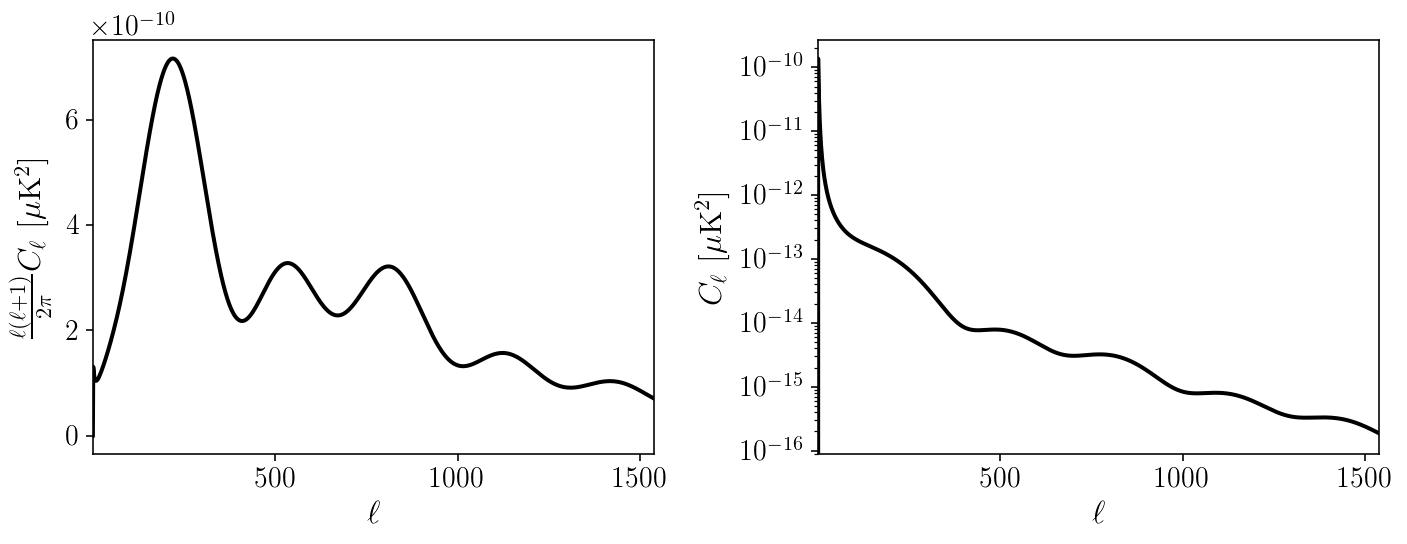

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(ells, Dells)
axs[1].plot(ells, Cells)
axs[0].set_xlabel(r'$\ell$')
axs[1].set_xlabel(r'$\ell$')
axs[0].set_ylabel(r'$\frac{\ell (\ell+1)}{2\pi} C_\ell$ [$\mu$K^2]')
axs[1].set_ylabel(r'$C_\ell$ [$\mu$K^2]')
axs[1].set_yscale('log')
axs[0].set_xlim([2, lmax])
axs[1].set_xlim([2, lmax])
fig.tight_layout()

## Making simulating CMB maps
We will now use the Healpix package to make mock CMB maps (Gaussian random fields) from our theoretical power spectrum.

In [5]:
cmbmap = hp.synfast(Cells, nside, 
                 lmax=lmax, mmax=None, alm=False, pol=False, 
                 pixwin=False, fwhm=0.0, sigma=None, new=False, verbose=True)

/Users/bl/anaconda/lib/python3.5/site-packages/healpy/sphtfunc.py:292: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


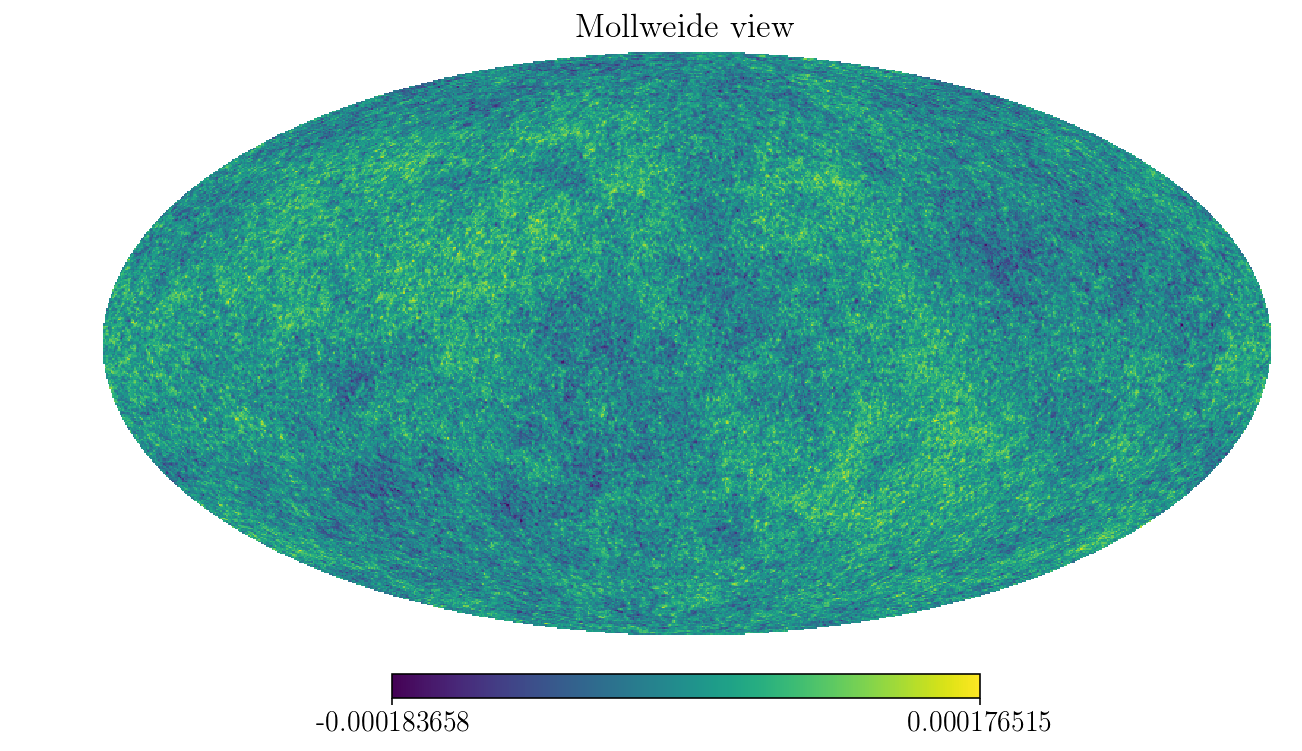

In [6]:
hp.mollview(cmbmap)

Again, this is a full sky, noiseless CMB map with no foregrounds. It is also at relatively high resolution.

## Gaussian Process and pixel-pixel correlations

We will now compute and show the full pixel-pixel correlation matrix. Since the scaling is pretty bad and this code not optimized at all, we will use a very small resolution.

In [7]:
nside = 16  # Healpix parameter, giving 12*nside**2 equal-area pixels on the sphere.
lmax = 3*nside # band-limit. Should be 2*nside < lmax < 4*nside to get information content.
print('Number of pixels: ', hp.nside2npix(nside))

Number of pixels:  3072


If we turn the previous equations around, we can write the expected correlations between pairs of locations on the sky:
$\langle T(\vec{n}) T^*(\vec{n}^\prime) \rangle = 
\sum_{\ell m}\sum_{\ell^\prime m^\prime} 
Y_{\ell m}(\vec{n}) \langle T_{\ell m} T^*_{\ell^\prime m^\prime} \rangle Y^*_{\ell^\prime m^\prime}(\vec{n}^\prime)$

$ \langle T_{\ell m} T^*_{\ell^\prime m^\prime} \rangle  = C_\ell \delta^K_{\ell \ell^\prime}  \delta^K_{m m^\prime}$

$\langle T(\vec{n}) T(\vec{n}^\prime) \rangle = 
\sum_{\ell m} C_\ell  Y_{\ell m}(\vec{n}) Y^*_{\ell m}(\vec{n}^\prime)$

Note that as soon as the sky is pixelized we can easily write this operation as two matrix products, with a diagonal matrix containing the power spectrum in the middle. In practice, we write those matrices as

$C_{i,j} = \langle T(\vec{n}_i) T(\vec{n}_j)$

$D_{\ell^2+\ell + m,j} = C_\ell \delta^K_{\ell^2+\ell + m, j}$

$Z_{\ell^2+\ell + m, i} = Y_{\ell m}(\vec{n}_i)$

So we simply write the covariance matrix as matrix products $C = Z^\dagger D Z$

In [8]:
import scipy.special
CellDiagMatrix = np.diag(np.concatenate([np.repeat(Cells[ell], 2*ell+1) for ell in range(lmax)]))
thetas, phis = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
YellmMatrix = np.zeros((lmax**2, hp.nside2npix(nside)), dtype=complex)
for ell in range(lmax):
    for em in range(-ell, ell+1):
        YellmMatrix[ell*ell + ell + em, :] = scipy.special.sph_harm(em, ell, phis, thetas)
pixelPixelCovarianceMatrix = np.abs(np.dot(np.conjugate(YellmMatrix).T, np.dot(CellDiagMatrix, YellmMatrix)))

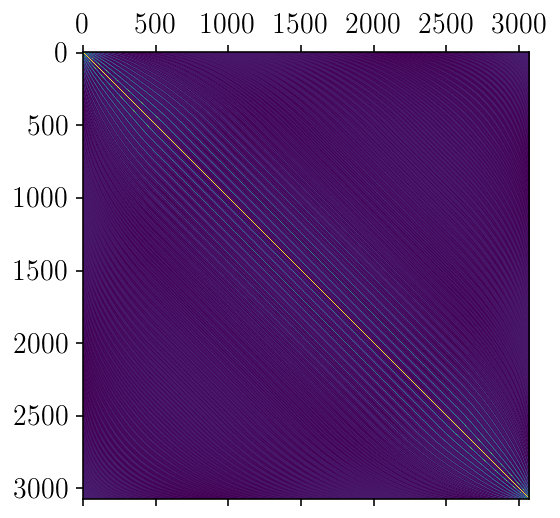

In [9]:
plt.matshow(pixelPixelCovarianceMatrix)

We can also simplify this formulation using the properties of spherical harmonics:

$
	\langle T(\vec{n}) T(\vec{n}^\prime) \rangle = \sum_{\ell=0}^L \ C_\ell \ \frac{2\ell+1}{4\pi} \ P_\ell(\vec{n} \cdot \vec{n}^\prime)
$

where $P_\ell(x)$ is the Legendre polynomial. (Those admit simple recurrence relations, so they could be calculated on the fly when performing this sum.)

In [10]:
def computeAngAngDotProduct(theta1, theta2, phi1, phi2):
    return np.cos(theta1)*np.cos(theta2) + np.sin(theta1)*np.sin(theta2)*np.cos(phi1-phi2)

def symrange(n):
    res = []
    for i in range(n):
        for j in range(i+1):
            res.append((i,j))
    return res

def computeHealpixAngAngDotProductMatrix(nside):
    npix = hp.nside2npix(nside)
    pixindices = np.arange(npix)
    angmat = np.ndarray((npix, npix))
    thetaphis = np.ndarray((npix, 2))
    thetaphis[:, 0], thetaphis[:, 1] = hp.pix2ang(nside, pixindices)
    angmat = computeAngAngDotProduct(
        thetaphis[:, None, 0], thetaphis[None, :, 0], 
        thetaphis[:, None, 1], thetaphis[None, :, 1])
    return angmat

pixelAnglesMatrix = computeHealpixAngAngDotProductMatrix(nside)

Let's first visualize the angle dot product matrix:

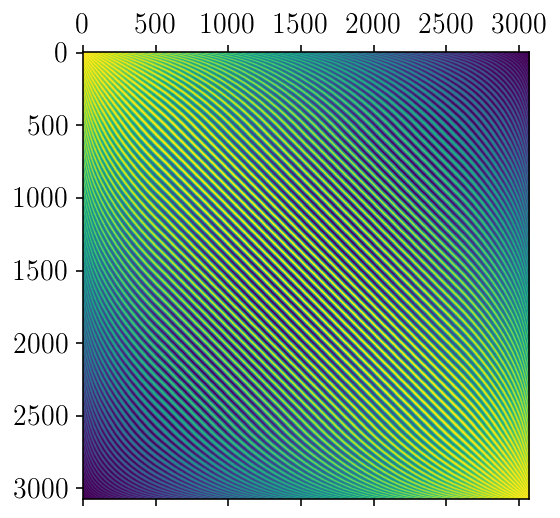

In [11]:
plt.matshow(pixelAnglesMatrix)

In [12]:
coefs = (2*ells[0:lmax] + 1)/(4*np.pi) * Cells[0:lmax]
coefs[0:2] = 0
pixelPixelCovarianceMatrix2 = np.polynomial.legendre.legval(pixelAnglesMatrix, coefs)

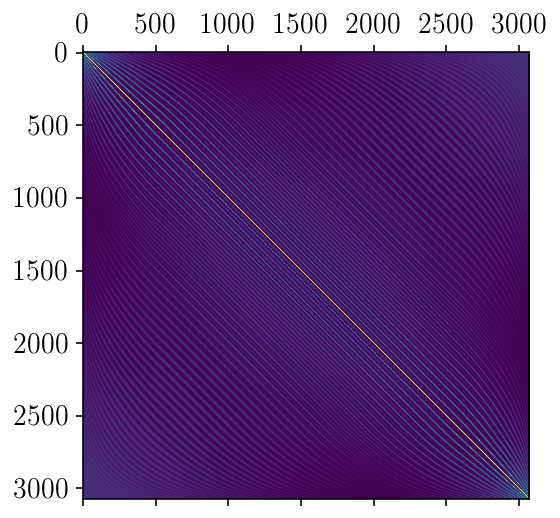

In [13]:
plt.matshow(pixelPixelCovarianceMatrix2)

We see that we obtain exactly the same answer, unsurprisingly. It is interesting to look at it in log abs scale:

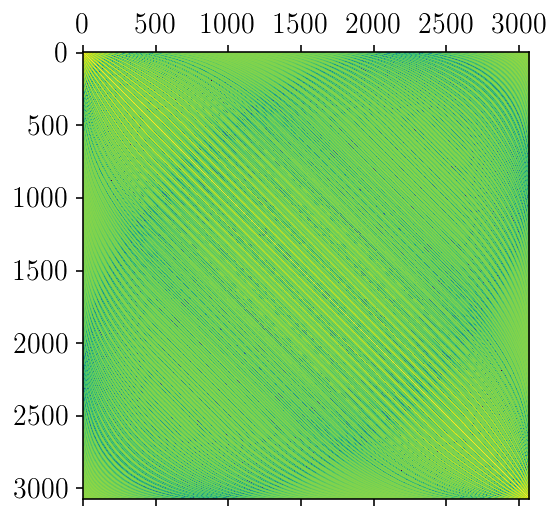

In [14]:
plt.matshow(np.log10((pixelPixelCovarianceMatrix)))

We can easily very this matrix numerically by simulating many maps and computing the correlation matrix ourself. The relative error steadily decrease as we increase the number of simulations, as expected, which shows our calculation is correct. (Be careful with those numbers since the number of piels quickly increase, and those calculations are very suboptimal. Ideally we should be calculation the correlation matrix on the fly, and also minimize the storage since it is bisymmetric so we could also compute and store one quarter of it.)

In [18]:
num_simulations = 10000
cmbmaps = np.zeros((num_simulations, hp.nside2npix(nside)))
for i in range(num_simulations):
    cmbmaps[i, :] = hp.synfast(Cells, nside, lmax=lmax, mmax=None, alm=False, pol=False, 
                pixwin=False, fwhm=0.0, sigma=None, new=False, verbose=False)
pixelPixelCovarianceMatrix_obs = np.cov(cmbmaps.T)

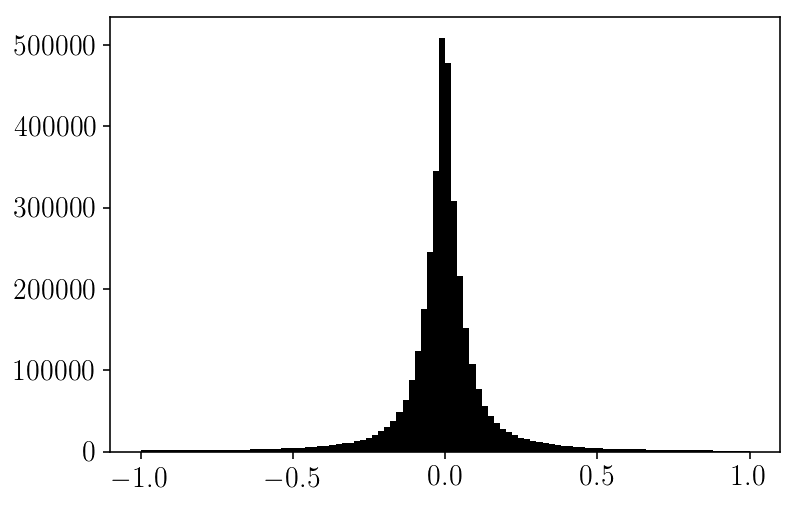

In [19]:
rel_error = pixelPixelCovarianceMatrix_obs/pixelPixelCovarianceMatrix - 1.0
_ = plt.hist(rel_error.ravel(), 100, range=[-1, 1])

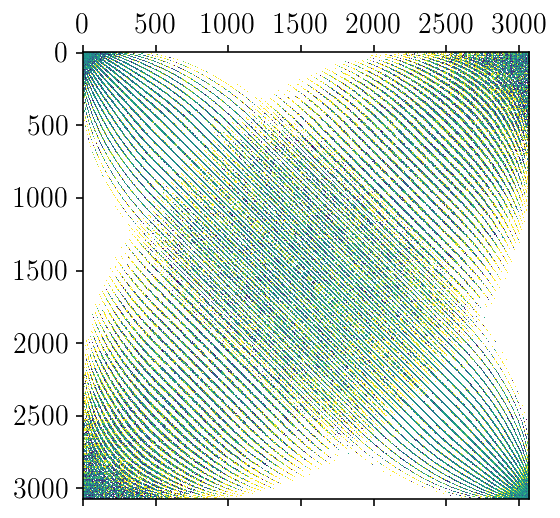

In [20]:
plt.matshow(rel_error, vmin=-.1, vmax=.1)

Note that if we wanted to work with a cartesian grid, or with the angles expressed in cartesian coordinates, we could call the following routine to obtain those for our Healpix grid:
x, y, z = hp.pix2vec(nside, pixindices)

## Comments
Let us make a few important remarks.
- We need to pixelize the sphere and find a suitable band limit $L$. This is a broad question but it has been well resolved and standardized in the context of the CMB. In our experiments we used the approximate schemes  [HEALPix](http://healpix.jpl.nasa.gov/). But there are exact quadrature schemes (sampling theorems on the sphere) like [SSHT](http://astro-informatics.github.io/ssht/). And we could also explore using cartesian coordinates, especially if we can speed up calculations!
- We don't simply observe noisy $T$ on the full sky. The true form of our data is a set of noisy $T$ maps  at different frequencies and with different noise and sky coverage. There are also foreground residuals, and we have parametric forms for those. The typical approach is to write a large multi-channel likelihood function and sample from all the parameters simultaneously, not  just $\Theta$.
- The noise is often colored (i.e., it is not white noise, with a flat power spectrum) but it is very diagonal. For this reason, there are messenger field approaches that exploit the diagonal-ness of the noise in pixel space and that of the signal in spherical harmonic space. Some useful references are https://arxiv.org/abs/1211.0585, https://arxiv.org/abs/1210.4931, and https://arxiv.org/abs/1705.01893.
- The many subtleties that bias the signal or the noise: beam mis-estimation, polarization leakage, etc. 
- Polarization fluctuations, which are a whole different game. For each sky location, we in fact observe noisy temperature flucturations (spin-0 field) and polarized flucturations (spin-2 field) which are correlated because of the signal, the noise, and the foregrounds.


A couple of extra references: 
- https://arxiv.org/abs/1004.2706 is a more technical review of power spectrum estimators and sky correlations
- https://arxiv.org/abs/astro-ph/0306506 is a classic pedagogical (but technical) review of the CMB likelihood. Both the language and the technique are outdated (w.r.t. Planck), but it gives a good introduction to the ideas and challenges of CMB data analysis.
- https://arxiv.org/abs/1509.08933 and https://arxiv.org/abs/1609.03577 are probably the state of the art for power spectrum estimation. They are written in a hybrid language to comply with both the CMB and galaxy survey literature.